In [86]:
from collections import defaultdict
import math
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as tnf
import torchvision as tv
import torchvision.transforms.functional as tvf

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

Using device: cuda:0


Define the VAE with following configurations:

**Recognition**:
- Training:
\begin{align}
\check{p}_{X|Y}(\cdot|y) = U(f(y) - 0.5, f(y) + 0.5),
\end{align}
where $f(\cdot)$ is a neural network (encoder).
- Testing: just simple quantization

**Prior**:
\begin{align}
\hat{p}_{X}(x) &\propto F_{\mu,\sigma}(x+0.5) - F_{\mu,\sigma}(x-0.5),
\end{align}
where $F_{\mu,\sigma}$ is the cdf of Normal($\mu,\sigma$), and $\mu,\sigma$ are learnable parameters.

**Emission**:
\begin{align}
\hat{p}_{Y|X}(y|x) &\propto e^{-\lambda \cdot d(g(x), y)},
\end{align}
where $\lambda$ is a scalar that we can tune, $d(\cdot)$ is a distortion metric (e.g., squared error), and $g(\cdot)$ is a neural network (decoder). \
This ensures that the negative log-likehood can be simply written as $\lambda \cdot d(g(x), y)$.


In [111]:
class ResidualBlock(nn.Module):
    """ A simple residual block
    """
    def __init__(self, channels):
        super().__init__()
        self.fc1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.fc2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.fc2.weight.data.fill_(0.0)
        self.fc2.bias.data.fill_(0.0)

    def forward(self, feature):
        res = self.fc1(tnf.gelu(feature))
        res = self.fc2(tnf.gelu(res))
        feature = feature + res
        return feature

def log_prob_prior(mean, log_scale, x):
    """ Compute the log probability under prior
    """
    gaussian = torch.distributions.Normal(mean, torch.exp(log_scale))
    prob_mass = gaussian.cdf(x + 0.5) - gaussian.cdf(x - 0.5)

    # workaround for numerical stability
    log_prob = torch.where(
        prob_mass > 1e-5,
        torch.log(prob_mass.clamp(min=1e-8)),
        gaussian.log_prob(x)
    )
    return log_prob

class ToyModel(nn.Module):
    def __init__(self, mse_lambda=64):
        super().__init__()
        in_dim = 1 # input dimension, 1x28x28
        hidden = 32 # hidden feature dimension at 7x7 resolution
        latent = 128 # latent variable dimension
        self.f = nn.Sequential(
            nn.Conv2d(in_dim, hidden, kernel_size=4, stride=4),
            *[ResidualBlock(hidden) for _ in range(4)],
            nn.Conv2d(hidden, latent, kernel_size=7, stride=7),
        ) # recognition neural network
        self.prior = nn.Parameter(torch.randn(1, latent*2, 1, 1)) # prior mean and scale
        self.g = nn.Sequential(
            nn.Conv2d(latent, hidden*7*7, kernel_size=1, stride=1),
            nn.PixelShuffle(7),
            *[ResidualBlock(hidden) for _ in range(4)],
            nn.Conv2d(hidden, in_dim*4*4, kernel_size=1, stride=1),
            nn.PixelShuffle(4),
        ) # emission neural network

        # self.entropy_bottleneck = EntropyBottleneck(M)
        self.mse_lmb = float(mse_lambda)

    def forward(self, y, return_im=False):
        nB, _, nH, nW = y.shape

        # recognition
        recognition_mean = self.f(y)
        # prior
        prior_params = self.prior.expand(nB, -1, 1, 1)
        pm, plogv = torch.chunk(prior_params, chunks=2, dim=1)
        # Sample
        if self.training: # during training, add u ~ U(-0.5, 0.5)
            u = torch.rand_like(recognition_mean) - 0.5
            x = recognition_mean + u
        else: # residual rounding during testing
            x = pm + torch.round(recognition_mean - pm)
        # Compute the KL
        log_prob = log_prob_prior(pm, plogv, x=x)
        kl = -1.0 * log_prob
        kl = kl.sum(1).mean(0) # sum over channels, mean over batch
        kl = kl / (nH*nW)
        # emission
        y_reconstruct = self.g(x)
        if return_im:
            return y_reconstruct

        # loss function
        mse = tnf.mse_loss(y_reconstruct, y, reduction='mean')
        loss = kl + self.mse_lmb * mse

        # compute metrics for logging
        stats = {
            'loss': loss,
            'bpdim': kl.item() * math.log2(math.e), # bits per dimension
            'psnr': -10 * math.log10(mse.item()), # Peak Signal to Noise Ratio (PSNR)
        }
        return stats

    def sample(self, n=1, quantize=False):
        prior_params = self.prior.expand(n, -1, 1, 1)
        pm, plogv = torch.chunk(prior_params, chunks=2, dim=1)
        x = pm + torch.randn_like(pm) * torch.exp(plogv)
        x = x + torch.rand_like(x) - 0.5
        if quantize:
            x = pm + torch.round(x - pm)
        y_reconstruct = self.g(x)
        return y_reconstruct



Initialize the MNIST dataset and several utility functions

In [110]:
def debug(t):
    print(type(t))
    print(f'dtype={t.dtype}, shape={t.shape}, min={t.min()}, max={t.max()}')

def tensorshow(x, title=''):
    """ Plot a tensor image
    """
    img = tvf.to_pil_image(x)
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

trainset = tv.datasets.MNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
testset = tv.datasets.MNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
# print(trainset.data[0].shape)
# tensorshow(trainset.data[0])

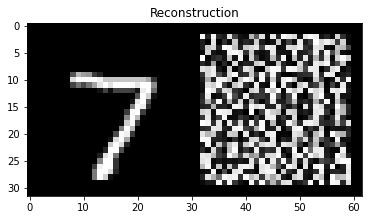

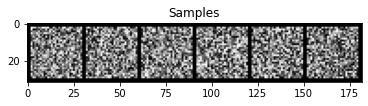

Epoch 0 count=60000.0000, loss=26.0527, bpdim=0.7482, psnr=17.0783,: 100%|██████████| 235/235 [00:05<00:00, 40.56it/s]
Epoch 1 count=60000.0000, loss=7.7998, bpdim=0.6472, psnr=21.4816,: 100%|██████████| 235/235 [00:05<00:00, 42.85it/s]
Epoch 2 count=60000.0000, loss=5.6412, bpdim=0.6063, psnr=22.9381,: 100%|██████████| 235/235 [00:05<00:00, 43.06it/s]
Epoch 3 count=60000.0000, loss=4.6539, bpdim=0.5898, psnr=23.8323,: 100%|██████████| 235/235 [00:05<00:00, 43.07it/s]
Epoch 4 count=60000.0000, loss=4.0099, bpdim=0.5850, psnr=24.5407,: 100%|██████████| 235/235 [00:05<00:00, 43.37it/s]
Epoch 5 count=60000.0000, loss=3.5505, bpdim=0.5841, psnr=25.1305,: 100%|██████████| 235/235 [00:05<00:00, 43.33it/s]
Epoch 6 count=60000.0000, loss=3.2027, bpdim=0.5848, psnr=25.6388,: 100%|██████████| 235/235 [00:05<00:00, 42.86it/s]
Epoch 7 count=60000.0000, loss=2.9425, bpdim=0.5878, psnr=26.0659,: 100%|██████████| 235/235 [00:05<00:00, 43.23it/s]
Epoch 8 count=60000.0000, loss=2.7366, bpdim=0.5915, ps

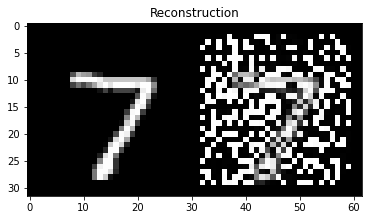

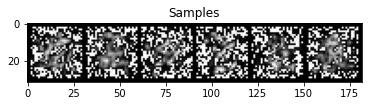

Epoch 10 count=60000.0000, loss=2.4214, bpdim=0.6000, psnr=27.0833,: 100%|██████████| 235/235 [00:05<00:00, 42.89it/s]
Epoch 11 count=60000.0000, loss=2.2995, bpdim=0.6042, psnr=27.3628,: 100%|██████████| 235/235 [00:05<00:00, 42.88it/s]
Epoch 12 count=60000.0000, loss=2.2041, bpdim=0.6081, psnr=27.5954,: 100%|██████████| 235/235 [00:05<00:00, 43.03it/s]
Epoch 13 count=60000.0000, loss=2.1263, bpdim=0.6117, psnr=27.7954,: 100%|██████████| 235/235 [00:07<00:00, 33.56it/s]
Epoch 14 count=60000.0000, loss=2.0544, bpdim=0.6156, psnr=27.9893,: 100%|██████████| 235/235 [00:06<00:00, 37.04it/s]
Epoch 15 count=60000.0000, loss=1.9973, bpdim=0.6186, psnr=28.1504,: 100%|██████████| 235/235 [00:06<00:00, 35.60it/s]
Epoch 16 count=60000.0000, loss=1.9503, bpdim=0.6214, psnr=28.2885,: 100%|██████████| 235/235 [00:06<00:00, 34.96it/s]
Epoch 17 count=60000.0000, loss=1.8984, bpdim=0.6246, psnr=28.4454,: 100%|██████████| 235/235 [00:06<00:00, 35.35it/s]
Epoch 18 count=60000.0000, loss=1.8455, bpdim=0.

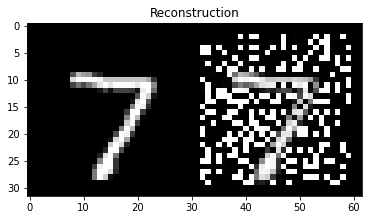

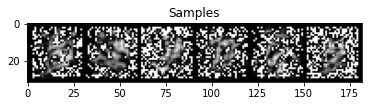

Epoch 20 count=60000.0000, loss=1.7631, bpdim=0.6319, psnr=28.8829,: 100%|██████████| 235/235 [00:06<00:00, 39.03it/s]
Epoch 21 count=60000.0000, loss=1.7364, bpdim=0.6334, psnr=28.9754,: 100%|██████████| 235/235 [00:06<00:00, 38.67it/s]
Epoch 22 count=60000.0000, loss=1.6990, bpdim=0.6351, psnr=29.1065,: 100%|██████████| 235/235 [00:06<00:00, 38.77it/s]
Epoch 23 count=60000.0000, loss=1.6711, bpdim=0.6367, psnr=29.2074,: 100%|██████████| 235/235 [00:06<00:00, 36.85it/s]
Epoch 24 count=60000.0000, loss=1.6490, bpdim=0.6378, psnr=29.2892,: 100%|██████████| 235/235 [00:06<00:00, 38.81it/s]
Epoch 25 count=60000.0000, loss=1.6206, bpdim=0.6395, psnr=29.3965,: 100%|██████████| 235/235 [00:06<00:00, 38.69it/s]
Epoch 26 count=60000.0000, loss=1.6074, bpdim=0.6403, psnr=29.4482,: 100%|██████████| 235/235 [00:06<00:00, 39.06it/s]
Epoch 27 count=60000.0000, loss=1.5858, bpdim=0.6413, psnr=29.5319,: 100%|██████████| 235/235 [00:05<00:00, 40.80it/s]
Epoch 28 count=60000.0000, loss=1.5630, bpdim=0.

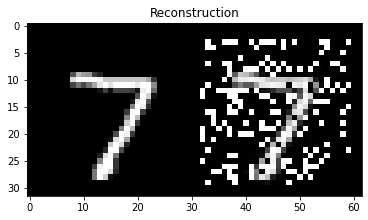

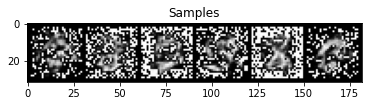

Epoch 30 count=60000.0000, loss=1.5298, bpdim=0.6442, psnr=29.7581,: 100%|██████████| 235/235 [00:06<00:00, 39.02it/s]
Epoch 31 count=60000.0000, loss=1.5211, bpdim=0.6445, psnr=29.7947,: 100%|██████████| 235/235 [00:06<00:00, 38.95it/s]
Epoch 32 count=60000.0000, loss=1.5011, bpdim=0.6454, psnr=29.8781,: 100%|██████████| 235/235 [00:06<00:00, 36.74it/s]
Epoch 33 count=60000.0000, loss=1.4829, bpdim=0.6461, psnr=29.9565,: 100%|██████████| 235/235 [00:06<00:00, 38.73it/s]
Epoch 34 count=60000.0000, loss=1.4749, bpdim=0.6464, psnr=29.9918,: 100%|██████████| 235/235 [00:06<00:00, 37.00it/s]
Epoch 35 count=60000.0000, loss=1.4588, bpdim=0.6466, psnr=30.0602,: 100%|██████████| 235/235 [00:06<00:00, 36.77it/s]
Epoch 36 count=60000.0000, loss=1.4481, bpdim=0.6474, psnr=30.1088,: 100%|██████████| 235/235 [00:06<00:00, 36.90it/s]
Epoch 37 count=60000.0000, loss=1.4329, bpdim=0.6475, psnr=30.1755,: 100%|██████████| 235/235 [00:06<00:00, 36.79it/s]
Epoch 38 count=60000.0000, loss=1.4232, bpdim=0.

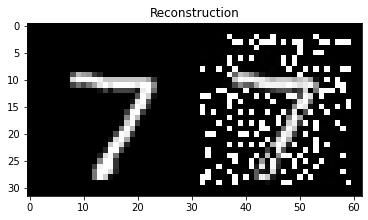

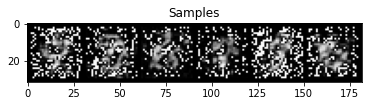

Epoch 40 count=60000.0000, loss=1.3982, bpdim=0.6483, psnr=30.3338,: 100%|██████████| 235/235 [00:06<00:00, 35.21it/s]
Epoch 41 count=60000.0000, loss=1.3914, bpdim=0.6485, psnr=30.3665,: 100%|██████████| 235/235 [00:06<00:00, 38.88it/s]
Epoch 42 count=60000.0000, loss=1.3822, bpdim=0.6484, psnr=30.4092,: 100%|██████████| 235/235 [00:06<00:00, 36.76it/s]
Epoch 43 count=60000.0000, loss=1.3705, bpdim=0.6484, psnr=30.4632,: 100%|██████████| 235/235 [00:06<00:00, 33.66it/s]
Epoch 44 count=60000.0000, loss=1.3619, bpdim=0.6486, psnr=30.5050,: 100%|██████████| 235/235 [00:06<00:00, 38.86it/s]
Epoch 45 count=60000.0000, loss=1.3524, bpdim=0.6486, psnr=30.5496,: 100%|██████████| 235/235 [00:06<00:00, 36.95it/s]
Epoch 46 count=60000.0000, loss=1.3472, bpdim=0.6484, psnr=30.5742,: 100%|██████████| 235/235 [00:06<00:00, 33.96it/s]
Epoch 47 count=60000.0000, loss=1.3356, bpdim=0.6483, psnr=30.6310,: 100%|██████████| 235/235 [00:06<00:00, 36.81it/s]
Epoch 48 count=60000.0000, loss=1.3307, bpdim=0.

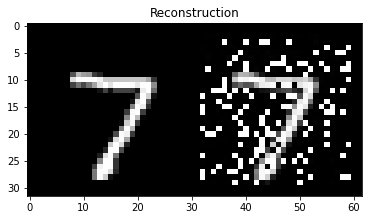

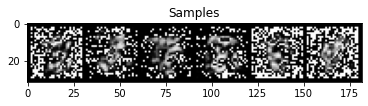

Epoch 50 count=60000.0000, loss=1.3146, bpdim=0.6479, psnr=30.7332,: 100%|██████████| 235/235 [00:06<00:00, 36.87it/s]
Epoch 51 count=60000.0000, loss=1.3036, bpdim=0.6480, psnr=30.7892,: 100%|██████████| 235/235 [00:06<00:00, 35.05it/s]
Epoch 52 count=60000.0000, loss=1.3036, bpdim=0.6473, psnr=30.7887,: 100%|██████████| 235/235 [00:06<00:00, 37.12it/s]
Epoch 53 count=60000.0000, loss=1.2918, bpdim=0.6473, psnr=30.8476,: 100%|██████████| 235/235 [00:06<00:00, 34.14it/s]
Epoch 54 count=60000.0000, loss=1.2854, bpdim=0.6475, psnr=30.8813,: 100%|██████████| 235/235 [00:06<00:00, 35.38it/s]
Epoch 55 count=60000.0000, loss=1.2786, bpdim=0.6472, psnr=30.9162,: 100%|██████████| 235/235 [00:07<00:00, 32.39it/s]
Epoch 56 count=60000.0000, loss=1.2709, bpdim=0.6475, psnr=30.9563,: 100%|██████████| 235/235 [00:07<00:00, 33.37it/s]
Epoch 57 count=60000.0000, loss=1.2677, bpdim=0.6471, psnr=30.9726,: 100%|██████████| 235/235 [00:06<00:00, 33.69it/s]
Epoch 58 count=60000.0000, loss=1.2596, bpdim=0.

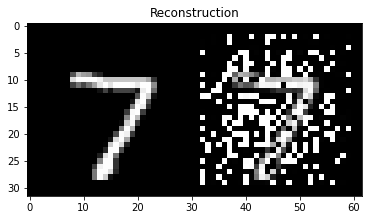

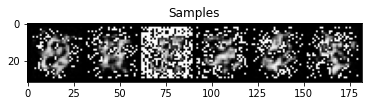

Epoch 60 count=60000.0000, loss=1.2486, bpdim=0.6464, psnr=31.0733,: 100%|██████████| 235/235 [00:06<00:00, 35.25it/s]
Epoch 61 count=60000.0000, loss=1.2446, bpdim=0.6462, psnr=31.0934,: 100%|██████████| 235/235 [00:07<00:00, 29.59it/s]
Epoch 62 count=60000.0000, loss=1.2432, bpdim=0.6461, psnr=31.1016,: 100%|██████████| 235/235 [00:07<00:00, 31.84it/s]
Epoch 63 count=60000.0000, loss=1.2338, bpdim=0.6457, psnr=31.1508,: 100%|██████████| 235/235 [00:07<00:00, 29.76it/s]
Epoch 64 count=60000.0000, loss=1.2319, bpdim=0.6455, psnr=31.1611,: 100%|██████████| 235/235 [00:07<00:00, 29.56it/s]
Epoch 65 count=60000.0000, loss=1.2307, bpdim=0.6451, psnr=31.1665,: 100%|██████████| 235/235 [00:07<00:00, 30.91it/s]
Epoch 66 count=60000.0000, loss=1.2197, bpdim=0.6451, psnr=31.2273,: 100%|██████████| 235/235 [00:07<00:00, 32.10it/s]
Epoch 67 count=60000.0000, loss=1.2182, bpdim=0.6449, psnr=31.2346,: 100%|██████████| 235/235 [00:05<00:00, 40.74it/s]
Epoch 68 count=60000.0000, loss=1.2150, bpdim=0.

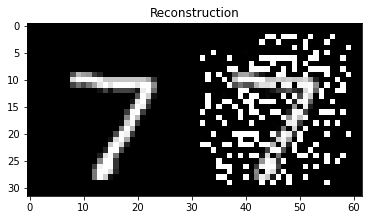

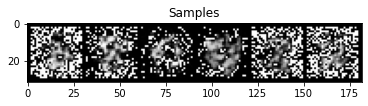

Epoch 70 count=60000.0000, loss=1.2036, bpdim=0.6441, psnr=31.3143,: 100%|██████████| 235/235 [00:05<00:00, 43.75it/s]
Epoch 71 count=60000.0000, loss=1.2033, bpdim=0.6442, psnr=31.3179,: 100%|██████████| 235/235 [00:05<00:00, 44.20it/s]
Epoch 72 count=60000.0000, loss=1.2003, bpdim=0.6437, psnr=31.3319,: 100%|██████████| 235/235 [00:05<00:00, 43.26it/s]
Epoch 73 count=60000.0000, loss=1.1975, bpdim=0.6433, psnr=31.3490,: 100%|██████████| 235/235 [00:05<00:00, 43.37it/s]
Epoch 74 count=60000.0000, loss=1.1888, bpdim=0.6435, psnr=31.3968,: 100%|██████████| 235/235 [00:05<00:00, 43.38it/s]
Epoch 75 count=60000.0000, loss=1.1891, bpdim=0.6433, psnr=31.3951,: 100%|██████████| 235/235 [00:05<00:00, 43.08it/s]
Epoch 76 count=60000.0000, loss=1.1838, bpdim=0.6430, psnr=31.4251,: 100%|██████████| 235/235 [00:05<00:00, 43.46it/s]
Epoch 77 count=60000.0000, loss=1.1815, bpdim=0.6427, psnr=31.4377,: 100%|██████████| 235/235 [00:05<00:00, 43.96it/s]
Epoch 78 count=60000.0000, loss=1.1768, bpdim=0.

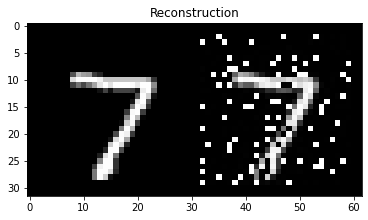

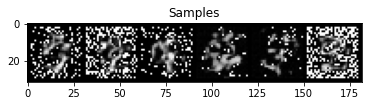

Epoch 80 count=60000.0000, loss=1.1751, bpdim=0.6419, psnr=31.4717,: 100%|██████████| 235/235 [00:05<00:00, 44.12it/s]
Epoch 81 count=60000.0000, loss=1.1723, bpdim=0.6416, psnr=31.4886,: 100%|██████████| 235/235 [00:05<00:00, 42.98it/s]
Epoch 82 count=60000.0000, loss=1.1681, bpdim=0.6415, psnr=31.5124,: 100%|██████████| 235/235 [00:05<00:00, 43.32it/s]
Epoch 83 count=60000.0000, loss=1.1633, bpdim=0.6415, psnr=31.5421,: 100%|██████████| 235/235 [00:05<00:00, 43.39it/s]
Epoch 84 count=60000.0000, loss=1.1611, bpdim=0.6411, psnr=31.5531,: 100%|██████████| 235/235 [00:05<00:00, 43.03it/s]
Epoch 85 count=60000.0000, loss=1.1583, bpdim=0.6410, psnr=31.5689,: 100%|██████████| 235/235 [00:05<00:00, 43.36it/s]
Epoch 86 count=60000.0000, loss=1.1552, bpdim=0.6408, psnr=31.5895,: 100%|██████████| 235/235 [00:05<00:00, 43.13it/s]
Epoch 87 count=60000.0000, loss=1.1537, bpdim=0.6408, psnr=31.5968,: 100%|██████████| 235/235 [00:05<00:00, 43.20it/s]
Epoch 88 count=60000.0000, loss=1.1497, bpdim=0.

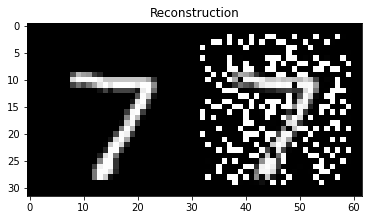

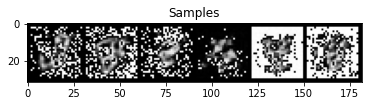

Epoch 90 count=60000.0000, loss=1.1463, bpdim=0.6403, psnr=31.6395,: 100%|██████████| 235/235 [00:05<00:00, 42.88it/s]
Epoch 91 count=60000.0000, loss=1.1421, bpdim=0.6401, psnr=31.6655,: 100%|██████████| 235/235 [00:05<00:00, 43.48it/s]
Epoch 92 count=60000.0000, loss=1.1423, bpdim=0.6400, psnr=31.6643,: 100%|██████████| 235/235 [00:05<00:00, 43.13it/s]
Epoch 93 count=60000.0000, loss=1.1369, bpdim=0.6397, psnr=31.6956,: 100%|██████████| 235/235 [00:05<00:00, 43.53it/s]
Epoch 94 count=60000.0000, loss=1.1363, bpdim=0.6397, psnr=31.7009,: 100%|██████████| 235/235 [00:05<00:00, 43.49it/s]
Epoch 95 count=60000.0000, loss=1.1344, bpdim=0.6394, psnr=31.7108,: 100%|██████████| 235/235 [00:05<00:00, 43.06it/s]
Epoch 96 count=60000.0000, loss=1.1326, bpdim=0.6390, psnr=31.7207,: 100%|██████████| 235/235 [00:05<00:00, 40.98it/s]
Epoch 97 count=60000.0000, loss=1.1277, bpdim=0.6392, psnr=31.7519,: 100%|██████████| 235/235 [00:05<00:00, 43.13it/s]
Epoch 98 count=60000.0000, loss=1.1238, bpdim=0.

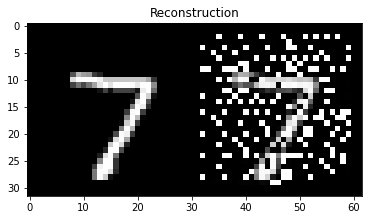

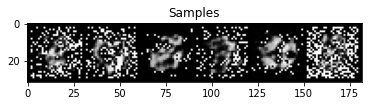

Epoch 100 count=60000.0000, loss=1.1205, bpdim=0.6390, psnr=31.7968,: 100%|██████████| 235/235 [00:05<00:00, 43.30it/s]
Epoch 101 count=60000.0000, loss=1.1196, bpdim=0.6387, psnr=31.8013,: 100%|██████████| 235/235 [00:05<00:00, 43.08it/s]
Epoch 102 count=60000.0000, loss=1.1207, bpdim=0.6383, psnr=31.7920,: 100%|██████████| 235/235 [00:05<00:00, 43.07it/s]
Epoch 103 count=60000.0000, loss=1.1161, bpdim=0.6383, psnr=31.8227,: 100%|██████████| 235/235 [00:05<00:00, 43.17it/s]
Epoch 104 count=60000.0000, loss=1.1143, bpdim=0.6384, psnr=31.8347,: 100%|██████████| 235/235 [00:05<00:00, 43.50it/s]
Epoch 105 count=60000.0000, loss=1.1109, bpdim=0.6383, psnr=31.8560,: 100%|██████████| 235/235 [00:05<00:00, 43.53it/s]
Epoch 106 count=60000.0000, loss=1.1101, bpdim=0.6383, psnr=31.8610,: 100%|██████████| 235/235 [00:05<00:00, 43.14it/s]
Epoch 107 count=60000.0000, loss=1.1085, bpdim=0.6380, psnr=31.8703,: 100%|██████████| 235/235 [00:05<00:00, 43.19it/s]
Epoch 108 count=60000.0000, loss=1.1065,

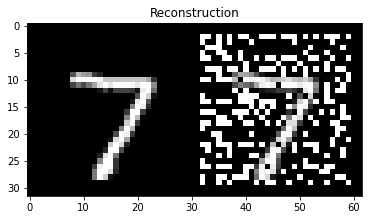

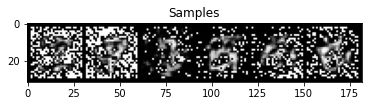

Epoch 110 count=60000.0000, loss=1.1036, bpdim=0.6376, psnr=31.9010,: 100%|██████████| 235/235 [00:05<00:00, 43.99it/s]
Epoch 111 count=60000.0000, loss=1.0998, bpdim=0.6379, psnr=31.9254,: 100%|██████████| 235/235 [00:05<00:00, 43.37it/s]
Epoch 112 count=60000.0000, loss=1.0973, bpdim=0.6378, psnr=31.9423,: 100%|██████████| 235/235 [00:05<00:00, 43.39it/s]
Epoch 113 count=60000.0000, loss=1.0968, bpdim=0.6377, psnr=31.9453,: 100%|██████████| 235/235 [00:05<00:00, 44.27it/s]
Epoch 114 count=60000.0000, loss=1.0941, bpdim=0.6377, psnr=31.9640,: 100%|██████████| 235/235 [00:05<00:00, 42.89it/s]
Epoch 115 count=60000.0000, loss=1.0958, bpdim=0.6374, psnr=31.9515,: 100%|██████████| 235/235 [00:05<00:00, 42.98it/s]
Epoch 116 count=60000.0000, loss=1.0922, bpdim=0.6374, psnr=31.9747,: 100%|██████████| 235/235 [00:05<00:00, 42.97it/s]
Epoch 117 count=60000.0000, loss=1.0911, bpdim=0.6372, psnr=31.9810,: 100%|██████████| 235/235 [00:05<00:00, 43.33it/s]
Epoch 118 count=60000.0000, loss=1.0863,

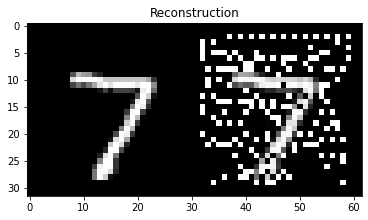

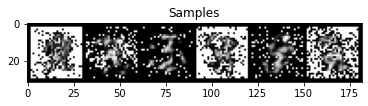

Epoch 120 count=60000.0000, loss=1.0854, bpdim=0.6371, psnr=32.0202,: 100%|██████████| 235/235 [00:05<00:00, 43.32it/s]
Epoch 121 count=60000.0000, loss=1.0820, bpdim=0.6369, psnr=32.0408,: 100%|██████████| 235/235 [00:05<00:00, 43.82it/s]
Epoch 122 count=60000.0000, loss=1.0835, bpdim=0.6368, psnr=32.0307,: 100%|██████████| 235/235 [00:05<00:00, 43.35it/s]
Epoch 123 count=60000.0000, loss=1.0810, bpdim=0.6367, psnr=32.0472,: 100%|██████████| 235/235 [00:05<00:00, 41.68it/s]
Epoch 124 count=60000.0000, loss=1.0813, bpdim=0.6368, psnr=32.0469,: 100%|██████████| 235/235 [00:05<00:00, 41.22it/s]
Epoch 125 count=60000.0000, loss=1.0753, bpdim=0.6365, psnr=32.0844,: 100%|██████████| 235/235 [00:05<00:00, 43.80it/s]
Epoch 126 count=60000.0000, loss=1.0757, bpdim=0.6368, psnr=32.0840,: 100%|██████████| 235/235 [00:05<00:00, 43.09it/s]
Epoch 127 count=60000.0000, loss=1.0736, bpdim=0.6365, psnr=32.0968,: 100%|██████████| 235/235 [00:05<00:00, 42.93it/s]
Epoch 128 count=60000.0000, loss=1.0748,

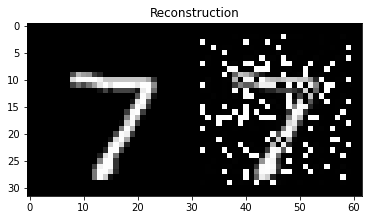

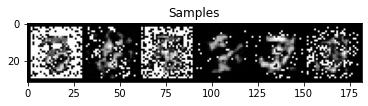

Epoch 130 count=60000.0000, loss=1.0707, bpdim=0.6362, psnr=32.1150,: 100%|██████████| 235/235 [00:05<00:00, 43.39it/s]
Epoch 131 count=60000.0000, loss=1.0691, bpdim=0.6362, psnr=32.1259,: 100%|██████████| 235/235 [00:05<00:00, 43.44it/s]
Epoch 132 count=60000.0000, loss=1.0678, bpdim=0.6361, psnr=32.1340,: 100%|██████████| 235/235 [00:05<00:00, 43.13it/s]
Epoch 133 count=60000.0000, loss=1.0672, bpdim=0.6359, psnr=32.1376,: 100%|██████████| 235/235 [00:05<00:00, 43.05it/s]
Epoch 134 count=60000.0000, loss=1.0646, bpdim=0.6359, psnr=32.1560,: 100%|██████████| 235/235 [00:05<00:00, 43.49it/s]
Epoch 135 count=60000.0000, loss=1.0634, bpdim=0.6357, psnr=32.1632,: 100%|██████████| 235/235 [00:05<00:00, 40.89it/s]
Epoch 136 count=60000.0000, loss=1.0627, bpdim=0.6357, psnr=32.1687,: 100%|██████████| 235/235 [00:05<00:00, 43.24it/s]
Epoch 137 count=60000.0000, loss=1.0603, bpdim=0.6357, psnr=32.1843,: 100%|██████████| 235/235 [00:05<00:00, 43.03it/s]
Epoch 138 count=60000.0000, loss=1.0609,

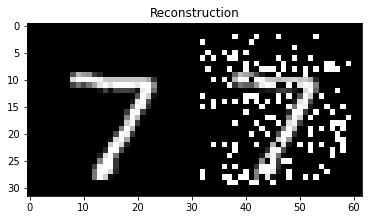

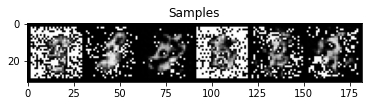

Epoch 140 count=60000.0000, loss=1.0569, bpdim=0.6358, psnr=32.2086,: 100%|██████████| 235/235 [00:05<00:00, 43.14it/s]
Epoch 141 count=60000.0000, loss=1.0580, bpdim=0.6356, psnr=32.2006,: 100%|██████████| 235/235 [00:05<00:00, 43.46it/s]
Epoch 142 count=60000.0000, loss=1.0549, bpdim=0.6354, psnr=32.2214,: 100%|██████████| 235/235 [00:05<00:00, 43.45it/s]
Epoch 143 count=60000.0000, loss=7.5133, bpdim=0.5590, psnr=23.5746,: 100%|██████████| 235/235 [00:05<00:00, 43.12it/s] 
Epoch 144 count=60000.0000, loss=2.7998, bpdim=0.5375, psnr=26.2767,: 100%|██████████| 235/235 [00:05<00:00, 40.86it/s]
Epoch 145 count=60000.0000, loss=2.1883, bpdim=0.5510, psnr=27.5453,: 100%|██████████| 235/235 [00:06<00:00, 38.72it/s]
Epoch 146 count=60000.0000, loss=1.8778, bpdim=0.5641, psnr=28.3869,: 100%|██████████| 235/235 [00:06<00:00, 35.25it/s]
Epoch 147 count=60000.0000, loss=1.6527, bpdim=0.5759, psnr=29.1265,: 100%|██████████| 235/235 [00:06<00:00, 38.73it/s]
Epoch 148 count=60000.0000, loss=1.5196

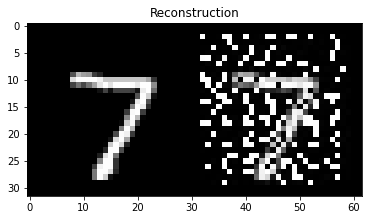

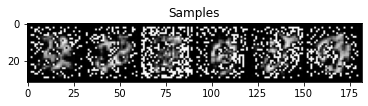

Epoch 150 count=60000.0000, loss=1.3908, bpdim=0.6045, psnr=30.2304,: 100%|██████████| 235/235 [00:06<00:00, 36.91it/s]
Epoch 151 count=60000.0000, loss=1.3484, bpdim=0.6114, psnr=30.4460,: 100%|██████████| 235/235 [00:06<00:00, 36.70it/s]
Epoch 152 count=60000.0000, loss=1.3224, bpdim=0.6167, psnr=30.5885,: 100%|██████████| 235/235 [00:06<00:00, 34.99it/s]
Epoch 153 count=60000.0000, loss=1.2928, bpdim=0.6211, psnr=30.7485,: 100%|██████████| 235/235 [00:06<00:00, 36.88it/s]
Epoch 154 count=60000.0000, loss=1.2785, bpdim=0.6242, psnr=30.8336,: 100%|██████████| 235/235 [00:06<00:00, 36.85it/s]
Epoch 155 count=60000.0000, loss=1.2616, bpdim=0.6270, psnr=30.9305,: 100%|██████████| 235/235 [00:06<00:00, 38.50it/s]
Epoch 156 count=60000.0000, loss=1.2480, bpdim=0.6290, psnr=31.0114,: 100%|██████████| 235/235 [00:06<00:00, 36.86it/s]
Epoch 157 count=60000.0000, loss=1.2355, bpdim=0.6306, psnr=31.0833,: 100%|██████████| 235/235 [00:06<00:00, 38.58it/s]
Epoch 158 count=60000.0000, loss=1.2245,

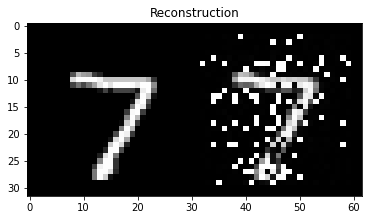

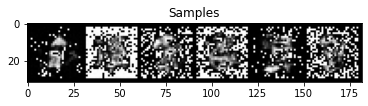

Epoch 160 count=60000.0000, loss=1.2076, bpdim=0.6342, psnr=31.2534,: 100%|██████████| 235/235 [00:06<00:00, 35.01it/s]
Epoch 161 count=60000.0000, loss=1.1939, bpdim=0.6351, psnr=31.3335,: 100%|██████████| 235/235 [00:06<00:00, 36.87it/s]
Epoch 162 count=60000.0000, loss=1.1914, bpdim=0.6356, psnr=31.3509,: 100%|██████████| 235/235 [00:05<00:00, 41.81it/s]
Epoch 163 count=60000.0000, loss=1.1851, bpdim=0.6359, psnr=31.3891,: 100%|██████████| 235/235 [00:06<00:00, 38.51it/s]
Epoch 164 count=60000.0000, loss=1.1791, bpdim=0.6365, psnr=31.4259,: 100%|██████████| 235/235 [00:06<00:00, 38.90it/s]
Epoch 165 count=60000.0000, loss=1.1746, bpdim=0.6368, psnr=31.4543,: 100%|██████████| 235/235 [00:06<00:00, 36.69it/s]
Epoch 166 count=60000.0000, loss=1.1683, bpdim=0.6372, psnr=31.4933,: 100%|██████████| 235/235 [00:06<00:00, 33.71it/s]
Epoch 167 count=60000.0000, loss=1.1613, bpdim=0.6375, psnr=31.5351,: 100%|██████████| 235/235 [00:06<00:00, 38.75it/s]
Epoch 168 count=60000.0000, loss=1.1609,

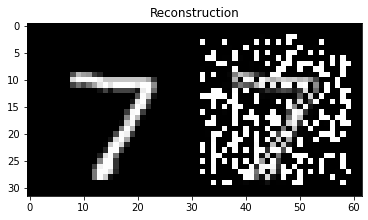

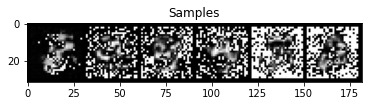

Epoch 170 count=60000.0000, loss=1.1529, bpdim=0.6376, psnr=31.5878,: 100%|██████████| 235/235 [00:06<00:00, 36.82it/s]
Epoch 171 count=60000.0000, loss=1.1517, bpdim=0.6375, psnr=31.5958,: 100%|██████████| 235/235 [00:06<00:00, 38.65it/s]
Epoch 172 count=60000.0000, loss=1.1458, bpdim=0.6372, psnr=31.6305,: 100%|██████████| 235/235 [00:06<00:00, 37.58it/s]
Epoch 173 count=60000.0000, loss=1.1452, bpdim=0.6374, psnr=31.6340,: 100%|██████████| 235/235 [00:06<00:00, 38.72it/s]
Epoch 174 count=60000.0000, loss=1.1389, bpdim=0.6374, psnr=31.6730,: 100%|██████████| 235/235 [00:06<00:00, 38.80it/s]
Epoch 175 count=60000.0000, loss=1.1416, bpdim=0.6370, psnr=31.6557,: 100%|██████████| 235/235 [00:07<00:00, 31.03it/s]
Epoch 176 count=60000.0000, loss=1.1331, bpdim=0.6372, psnr=31.7083,: 100%|██████████| 235/235 [00:07<00:00, 32.02it/s]
Epoch 177 count=60000.0000, loss=1.1324, bpdim=0.6372, psnr=31.7131,: 100%|██████████| 235/235 [00:07<00:00, 29.43it/s]
Epoch 178 count=60000.0000, loss=1.1293,

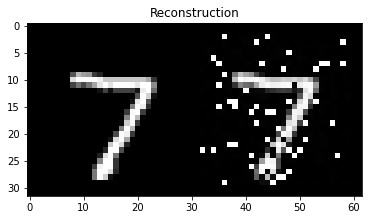

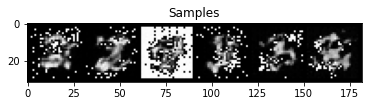

Epoch 180 count=60000.0000, loss=1.1207, bpdim=0.6370, psnr=31.7868,: 100%|██████████| 235/235 [00:07<00:00, 30.85it/s]
Epoch 181 count=60000.0000, loss=1.1261, bpdim=0.6367, psnr=31.7511,: 100%|██████████| 235/235 [00:07<00:00, 30.84it/s]
Epoch 182 count=60000.0000, loss=1.1192, bpdim=0.6367, psnr=31.7942,: 100%|██████████| 235/235 [00:07<00:00, 30.86it/s]
Epoch 183 count=60000.0000, loss=1.1168, bpdim=0.6368, psnr=31.8102,: 100%|██████████| 235/235 [00:07<00:00, 30.77it/s]
Epoch 184 count=60000.0000, loss=1.1166, bpdim=0.6366, psnr=31.8121,: 100%|██████████| 235/235 [00:07<00:00, 30.72it/s]
Epoch 185 count=60000.0000, loss=1.1137, bpdim=0.6364, psnr=31.8289,: 100%|██████████| 235/235 [00:07<00:00, 32.26it/s]
Epoch 186 count=60000.0000, loss=1.1110, bpdim=0.6366, psnr=31.8470,: 100%|██████████| 235/235 [00:07<00:00, 30.64it/s]
Epoch 187 count=60000.0000, loss=1.1085, bpdim=0.6366, psnr=31.8632,: 100%|██████████| 235/235 [00:07<00:00, 30.89it/s]
Epoch 188 count=60000.0000, loss=1.1089,

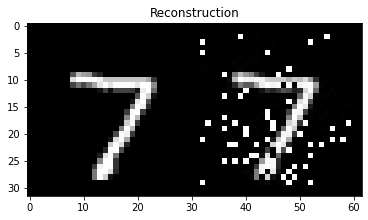

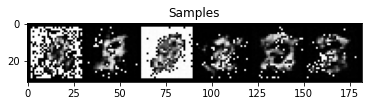

Epoch 190 count=60000.0000, loss=1.1037, bpdim=0.6363, psnr=31.8937,: 100%|██████████| 235/235 [00:07<00:00, 31.12it/s]
Epoch 191 count=60000.0000, loss=1.1056, bpdim=0.6361, psnr=31.8804,: 100%|██████████| 235/235 [00:07<00:00, 29.40it/s]
Epoch 192 count=60000.0000, loss=1.0977, bpdim=0.6361, psnr=31.9315,: 100%|██████████| 235/235 [00:07<00:00, 29.55it/s]
Epoch 193 count=60000.0000, loss=1.0994, bpdim=0.6362, psnr=31.9208,: 100%|██████████| 235/235 [00:07<00:00, 29.47it/s]
Epoch 194 count=60000.0000, loss=1.0951, bpdim=0.6363, psnr=31.9499,: 100%|██████████| 235/235 [00:07<00:00, 30.64it/s]
Epoch 195 count=60000.0000, loss=1.0953, bpdim=0.6361, psnr=31.9480,: 100%|██████████| 235/235 [00:07<00:00, 30.60it/s]
Epoch 196 count=60000.0000, loss=1.0952, bpdim=0.6360, psnr=31.9485,: 100%|██████████| 235/235 [00:07<00:00, 30.89it/s]
Epoch 197 count=60000.0000, loss=1.0911, bpdim=0.6359, psnr=31.9758,: 100%|██████████| 235/235 [00:07<00:00, 31.24it/s]
Epoch 198 count=60000.0000, loss=1.0906,

In [113]:
model = ToyModel(mse_lambda=1024)
model = model.to(device=device)

dataloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(200):
    epoch_stats = defaultdict(float)
    epoch_stats['count'] = 0

    # logging
    if epoch % 10 == 0:
        model.eval()
        im = tvf.to_tensor(Image.fromarray(testset.data[0].numpy(), mode='L'))
        im = im.unsqueeze_(0).to(device=device)
        im_hat = model.forward(im, return_im=True)
        to_show = tv.utils.make_grid([im[0], im_hat[0]])
        tensorshow(to_show, title='Reconstruction')
        samples = model.sample(n=6)
        to_show = tv.utils.make_grid(samples)
        tensorshow(to_show, title='Samples')

    model.train()
    pbar = tqdm(dataloader)
    for im, label in pbar:
        im = im.to(device=device)
        stats = model.forward(im)
        loss = stats['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # logging
        bs = im.shape[0] # batch size
        count = epoch_stats['count']
        for k, v in stats.items():
            epoch_stats[k] = (count * epoch_stats[k] + v*bs) / float(count + bs)
        epoch_stats['count'] += bs
        msg = ' '.join([f'{k}={float(v):.4f},' for k,v in epoch_stats.items()])
        pbar.set_description(f'Epoch {epoch} ' + msg)
